# Install Requirements

In [1]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 5.0 MB/s eta 0:00:0000:0100:01


# Liberaries

In [2]:
#Disable all warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
from skimage.io import  imread, imshow
from skimage.transform import  resize, rescale
from skimage.color import rgb2gray
from os import listdir, path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,os.path
import visualkeras
from PIL import ImageFont
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# Loading The Data by Image Data Generator

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [5]:
train_gen = datagen.flow_from_directory(directory = '/kaggle/input/railway-track-fault-detection-resized-224-x-224/train', 
                                          class_mode="categorical",
                                          target_size = (299, 299),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 299 images belonging to 2 classes.


In [6]:
val_gen = datagen.flow_from_directory(directory = '/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid', 
                                          class_mode="categorical",
                                          target_size = (299, 299),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 62 images belonging to 2 classes.


In [7]:
test_gen = datagen.flow_from_directory(directory = '/kaggle/input/railway-track-fault-detection-resized-224-x-224/test', 
                                          class_mode="categorical",
                                          target_size = (299, 299),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          shuffle = False)

Found 22 images belonging to 2 classes.


# Model Architecture

In [8]:
# to make this notebook's output stable across runs

def reset_graph(seed=41):
    tf.random.set_seed(seed)
    np.random.seed(seed) 

## InceptionV3 Model

In [9]:
InceptionV3_model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


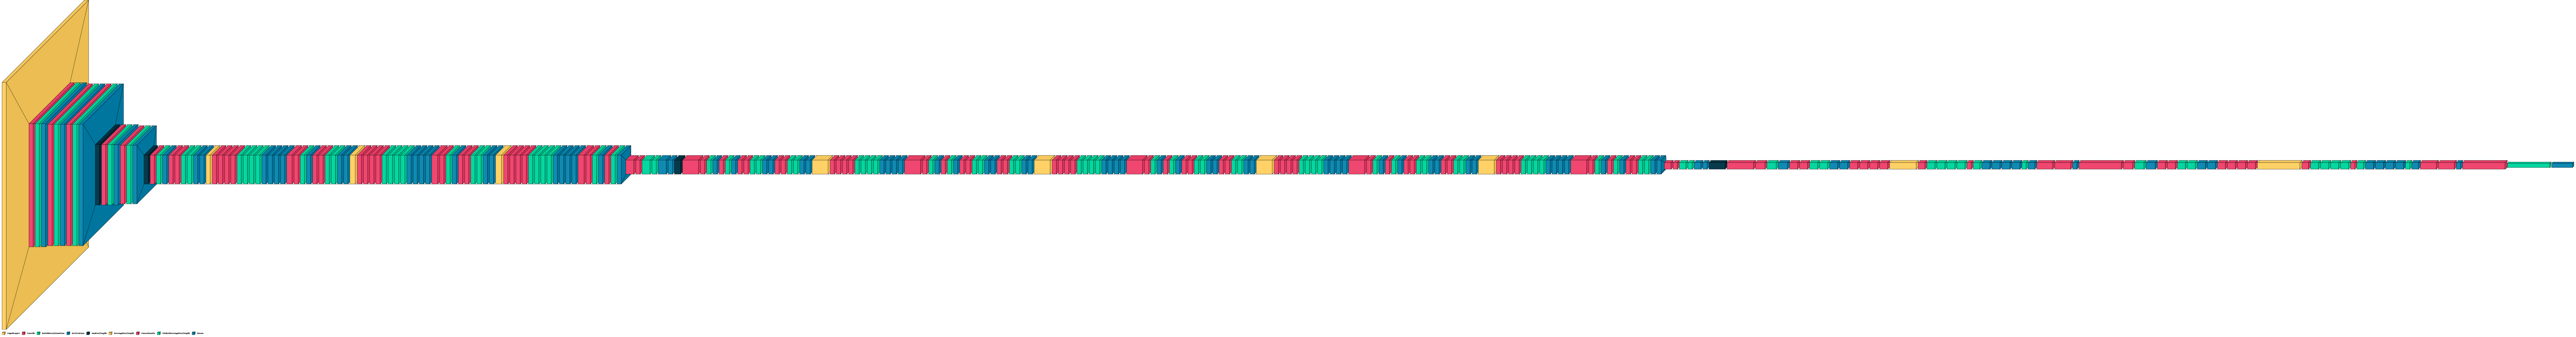

In [10]:
visualkeras.layered_view(InceptionV3_model, legend=True)

In [11]:
InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [12]:
plot_model(InceptionV3_model, to_file= 'InceptionV3_model.png', show_shapes = True, show_layer_names=True)

# Our Tuning on the Model

In [14]:
# We fix the parameters of the pretrained model
InceptionV3_model.trainable = False

In [15]:
# Add data augmentation layers
augmentation = tf.keras.Sequential([
   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), 
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
   tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.15),
])

In [17]:
# Here we add final layers to the first model
inputs = InceptionV3_model.input
x = augmentation(inputs)

x = BatchNormalization()(InceptionV3_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.45, seed=1234)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45, seed=1235)(x)
x = Flatten()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

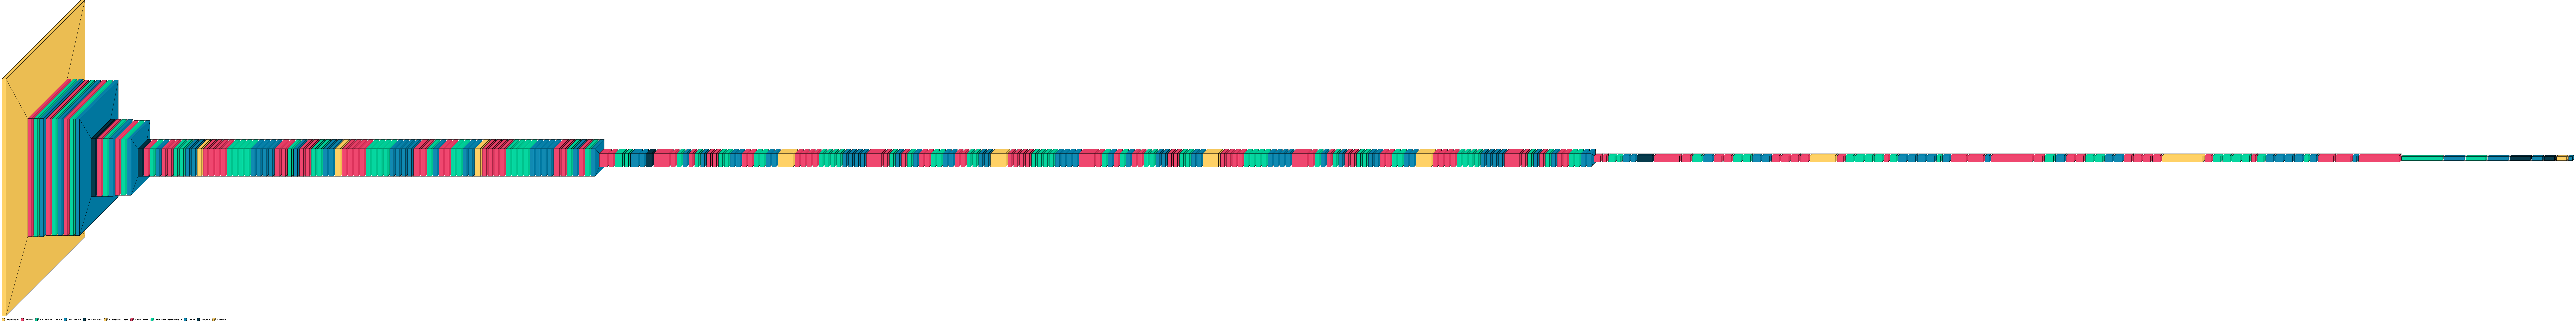

In [18]:
visualkeras.layered_view(model, legend=True)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
plot_model(model, to_file= 'model.png', show_shapes = True, show_layer_names=True)

# Model training

In [21]:
reset_graph(seed=9)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [22]:
model_training = model.fit(train_gen, epochs=10, verbose=1, validation_data=val_gen)

Epoch 1/10
10/10 [==============================] - 29s 894ms/step - loss: 0.7096 - accuracy: 0.5251 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 2s 207ms/step - loss: 0.5762 - accuracy: 0.6957 - val_loss: 0.6711 - val_accuracy: 0.5968
Epoch 3/10
10/10 [==============================] - 2s 223ms/step - loss: 0.4656 - accuracy: 0.7726 - val_loss: 0.6698 - val_accuracy: 0.5968
Epoch 4/10
10/10 [==============================] - 2s 211ms/step - loss: 0.4155 - accuracy: 0.8161 - val_loss: 0.6597 - val_accuracy: 0.6290
Epoch 5/10
10/10 [==============================] - 2s 212ms/step - loss: 0.3401 - accuracy: 0.8595 - val_loss: 0.6546 - val_accuracy: 0.6613
Epoch 6/10
10/10 [==============================] - 2s 222ms/step - loss: 0.2545 - accuracy: 0.9130 - val_loss: 0.6559 - val_accuracy: 0.5968
Epoch 7/10
10/10 [==============================] - 2s 217ms/step - loss: 0.2094 - accuracy: 0.9231 - val_loss: 0.7417 - val_accuracy: 0.5161
Epoch

# History

In [23]:
# History
pd.DataFrame(model_training.history)

loss  accuracy  val_loss  val_accuracy
0  0.709615  0.525084  0.687322      0.500000
1  0.576195  0.695652  0.671080      0.596774
2  0.465576  0.772575  0.669764      0.596774
3  0.415483  0.816054  0.659724      0.629032
4  0.340111  0.859532  0.654555      0.661290
5  0.254533  0.913043  0.655879      0.596774
6  0.209419  0.923077  0.741726      0.516129
7  0.190738  0.933110  0.663318      0.580645
8  0.172656  0.936455  0.652260      0.596774
9  0.155185  0.943144  0.820052      0.500000

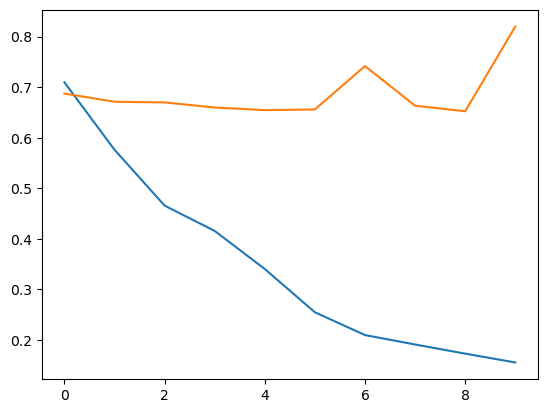

In [24]:
# Plot the Losses
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])

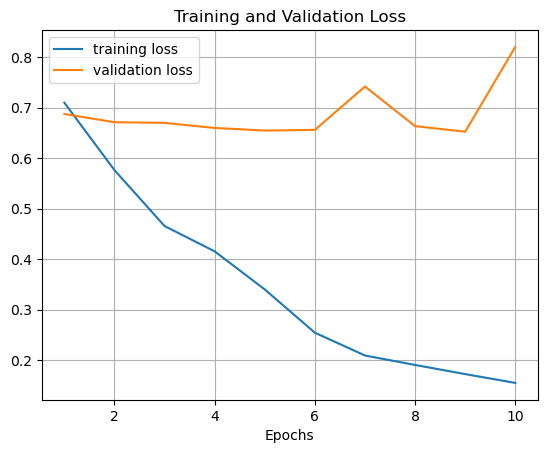

In [25]:
# Here we make the first plot for Loss
Epochs = [i+1 for i in range(len(model_training.history['accuracy']))]

plt.plot(Epochs, model_training.history['loss'], label = 'training loss')
plt.plot(Epochs, model_training.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

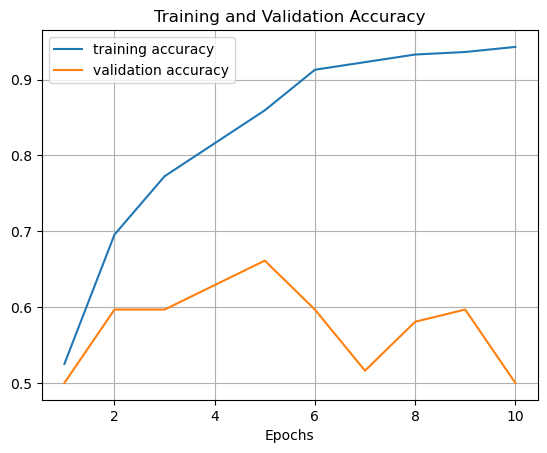

In [26]:
# Here we make the first plot for accuracy
Epochs = [i+1 for i in range(len(model_training.history['accuracy']))]

plt.plot(Epochs, model_training.history['accuracy'], label = 'training accuracy')
plt.plot(Epochs, model_training.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

# Evaluation

In [27]:
results = model.evaluate(test_gen, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.8498 - accuracy: 0.5000
